# Introduction

While exploring the Airbnb data I found it interesting that there was roughly a 50/50 split between rentals that allowed for a single night stay and those that didn't.  I thought it would be interesting to dig into this further and see whether or not the other variables present might help to predict whether a property allows for one night stays or not.

Using Logistic Regression I found that properties with lower price, higher number of reviews, less strict cancellation policies, owned by non-superhosts, and not requiring a photo id of the guest were more likely to offer a one night stay policy. The model had a 67% accuracy rate on the test dataset.

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import statsmodels.api as sm

from pprint import pprint
%matplotlib inline

# df = pd.read_csv('./survey_results_public.csv')
# df.head()

## Step 1: Gather
Only keep variables of interest that can be modeled with logistic regression (i.e. exclude ID numbers, long text fields, and other fields which have little to no variation (such as country)

In [99]:
df = pd.read_csv('~/UdacityDesktop/listings.csv')
df2 = df[[
'host_response_rate',
'host_acceptance_rate',
'host_is_superhost',
'host_total_listings_count',
'host_has_profile_pic',
'host_identity_verified',
'neighbourhood_group_cleansed',
'property_type',
'room_type',
'accommodates',
'bathrooms',
'bedrooms',
'beds',
'bed_type',
'amenities',
'square_feet',
'price',
'weekly_price',
'monthly_price',
'security_deposit',
'cleaning_fee',
'guests_included',
'extra_people',
'minimum_nights',
'maximum_nights',
'availability_30',
'number_of_reviews',
'review_scores_rating',
'requires_license',
'instant_bookable',
'cancellation_policy',
'require_guest_profile_picture',
'require_guest_phone_verification',
'calculated_host_listings_count',
'reviews_per_month']].copy()
df2.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,property_type,room_type,accommodates,...,availability_30,number_of_reviews,review_scores_rating,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,96%,100%,f,3.0,t,t,Queen Anne,Apartment,Entire home/apt,4,...,14,207,95.0,f,f,moderate,f,f,2,4.07
1,98%,100%,t,6.0,t,t,Queen Anne,Apartment,Entire home/apt,4,...,13,43,96.0,f,f,strict,t,t,6,1.48
2,67%,100%,f,2.0,t,t,Queen Anne,House,Entire home/apt,11,...,1,20,97.0,f,f,strict,f,f,2,1.15
3,NaN,NaN,f,1.0,t,t,Queen Anne,Apartment,Entire home/apt,3,...,0,0,NaN,f,f,flexible,f,f,1,NaN
4,100%,NaN,f,2.0,t,t,Queen Anne,House,Entire home/apt,6,...,30,38,92.0,f,f,strict,f,f,1,0.89


# Step 2: Assess

First I Determine whether any variable has too many missing values to be relevant to modeling.  Below I show all columns that have more than 1% of their values missing.  After checking for null values below, I determine that only square feet should be removed as over 97% of the values are missing.  This is unfortunate, in my opinion, as square footage would likely be very relevant for predicting things such as nightly price.

Weekly_price, monthly_price, security_deposit, and cleaning_fee also have high percentages of missing values.  However, in those cases, the missing values can be set to 0 because a missing likely just means that there is no extra fee for those items.  

In the case of host_acceptance_rate, review_per_month, review_scores_rating, and host_response_rate, an average of the column will be used in their place instead of a null value.

In [100]:
percent_missing = (df2.isnull()/df2.shape[0]).sum()
percent_missing[percent_missing > 0.01].sort_values(ascending=False)


square_feet             0.974594
monthly_price           0.602672
security_deposit        0.511262
weekly_price            0.473808
cleaning_fee            0.269775
host_acceptance_rate    0.202462
review_scores_rating    0.169460
reviews_per_month       0.164222
host_response_rate      0.136983
dtype: float64

In [101]:
df2.dtypes

host_response_rate                   object
host_acceptance_rate                 object
host_is_superhost                    object
host_total_listings_count           float64
host_has_profile_pic                 object
host_identity_verified               object
neighbourhood_group_cleansed         object
property_type                        object
room_type                            object
accommodates                          int64
bathrooms                           float64
bedrooms                            float64
beds                                float64
bed_type                             object
amenities                            object
square_feet                         float64
price                                object
weekly_price                         object
monthly_price                        object
security_deposit                     object
cleaning_fee                         object
guests_included                       int64
extra_people                    

# Step 3: Clean Up

I convert host_response_rate and host_acceptance_rate to float rather than objects. This allows for numeric manipulations down the road.  I also remove square_feet due to a high number of missing values.

In [102]:
df2['host_response_rate'] = df2['host_response_rate'].str.strip('%').astype(float)
df2['host_acceptance_rate'] = df2['host_acceptance_rate'].str.strip('%').astype(float)


In [103]:
df2 = df2.drop(['square_feet'], axis=1)


I convert price to numeric rather than being categorical.  I was not able to figure out how to use str.strip to remove commas so the one price with a comma I simply replaced with a text value without (shown below) prior to converting the price field to a float datatype.

In [104]:
df2.loc[(df2['price']=='$1,000.00'),'price'] = '$1000.00'
# df2['price'] = df2['price'].replace(',', '')
df2['price'] = df2['price'].str.strip('$')
df2['price'].head(1000)
df2['price'] = df2['price'].astype(float)

I drop any missing minimum night rows (as this is related to my outcome variable of having one night options for stay) and also convert it to a binary variable for modeling.

In [105]:
df2['one_night_option'] = np.where(df2['minimum_nights']==1,1,0)
df2['house_or_other'] = np.where(df2['property_type'] == 'House','House','Non-House')
df2['shared_room'] = np.where(df2['room_type']== 'Entire home/apt ', 'No ','Yes')


Next I drop minimum_nights, property_type, and room_type in favor of the variables I created.

In [106]:
df2 = df2.drop(['minimum_nights', 'property_type', 'room_type'], axis=1)

For some of the columns (has_weekly_price, has_monthly_price, has_security_deposit, has_extra_people_fee, has_cleaning_fee), imputing a value for the missing wouldn't be appropriate because it may simply mean that there isn't one.  It also doesn't make sense to make them 0 either for that same reason.  Therefore I take those variables and convert them to a binary variable which just indicated whether or not they have them.

In [107]:
df2['has_weekly_price'] = np.where(df2['weekly_price'].isnull(),0,1)
df2['has_monthly_price'] = np.where(df2['monthly_price'].isnull(),0,1)
df2['has_security_deposit'] = np.where(df2['security_deposit'].isnull(),0,1)
df2['has_extra_people_fee'] = np.where(df2['extra_people']=='$0.00',0,1)
df2['has_cleaning_fee'] = np.where(df2['cleaning_fee'].isnull(),0,1)
df2 = df2.drop(['weekly_price','monthly_price','security_deposit','extra_people','cleaning_fee'], axis=1)

Next I make a correlation plot with the cleaned up data.  I found the template for this from at https://seaborn.pydata.org/examples/many_pairwise_correlations.html.  I'm making a correlation plot to see whether or not it appears that some of the variables in this dataset might relate to whether a host allows for single night stays.  I'm looking for darker boxes in the one_night_option variable row.  Based on the data below it does appear as though some variables such as the number accomodated or the number of reviews have at least a weak to moderate relationship.

In [108]:
# corr

# Step 4: Visualize

I first want to understand where correlations might exist between the different variables.  Specifically, I'm looking to understand where having a one night option might show a relationship with the other variables of interest.  I do this by using a correlation mantrix.  I found a good seaborn code example to start from out at initial helper code: https://seaborn.pydata.org/examples/many_pairwise_correlations.html.

As can be seen, there are a cluster of highly correlated variables (accomodates, bathrooms, bedrooms, beds, price, guests included.)  I will plan to only keep accomodates and drop bedrooms, bathrooms, and guests included as these seem very redundant and tell the same story.  While price is related, there may be other interesting information in price that might not be related only to the number of rooms or how many can be accomodated.  Therefore, I'll keep it. 

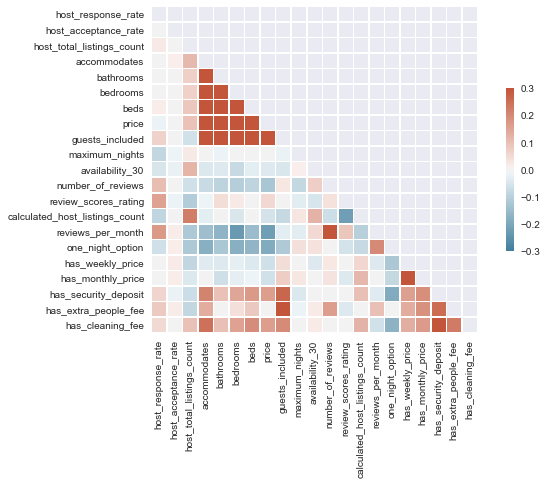

In [109]:
corr = df2.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [110]:
corrDF = pd.DataFrame(corr['one_night_option']).sort_values(by=['one_night_option'])
corrDF

# abs_corr.dtypes
# abs_corr['abs_corr'] = abs(abs_corr['one_night_option'])
# abs_corr = pd.DataFrame(abs_corr)
# abs_corr.dtypes


,one_night_option
price,-0.192059
has_security_deposit,-0.187662
bedrooms,-0.179355
accommodates,-0.178515
has_cleaning_fee,-0.171673
beds,-0.165427
bathrooms,-0.123320
has_weekly_price,-0.120210
host_total_listings_count,-0.118016
guests_included,-0.116886


# Visual Differences in One Night Stay Options and Other Variables



Does there tend to be a price difference between one night option rentals and those that require two or more nights?  I used a histogram that shows overlap initially to view price vs one night option status.  I found a good starter example https://datavizpyr.com/overlapping-histograms-with-matplotlib-in-python/ for help on this.  As can be seen, the one night option rentals have lower prices.

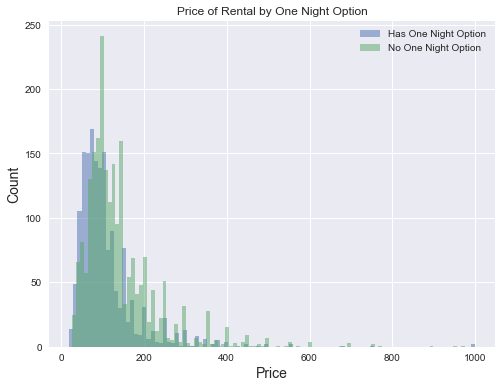

In [111]:
plt.figure(figsize=(8,6))
plt.hist(df2[df2['one_night_option']==1]['price'], bins=100, alpha=0.5, label="Has One Night Option")
plt.hist(df2[df2['one_night_option']==0]['price'], bins=100, alpha=0.5, label="No One Night Option")
plt.xlabel("Price", size=14)
plt.ylabel("Count", size=14)
plt.title("Price of Rental by One Night Option")
plt.legend(loc='upper right')
plt.savefig("overlapping_histograms_with_matplotlib_Python.png")

To see this even better using bins, I created a 5-bin variable on price and looked at ther percentage of rentals within each bin that offered a one-night option.  I found out how to do this at https://stackoverflow.com/questions/45273731/binning-a-column-with-python-pandas.

As you can see, the higher priced options have a lower percentage with a one-night option.

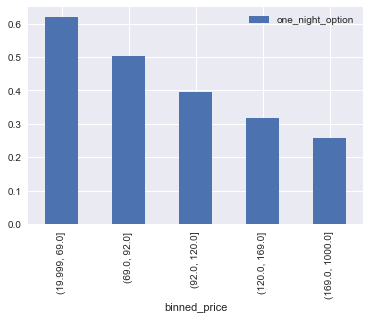

In [112]:
df2['binned_price'] = pd.qcut(df2['price'], q=5)

price_one_night = df2[['binned_price','one_night_option']].groupby(['binned_price']).mean().plot.bar()
price_one_night

I also looked at the reviews per month as this variable also appeared to have a higher correlation with one night stay options.  Below you find the binned version of the number of reviews vs the percentage with a one night option.  While not all bins show an increase in percentage with one night stays vs number of reivews, directionally this looks to be the case.

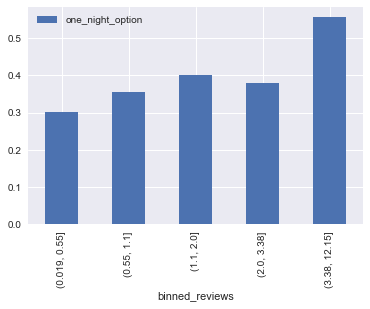

In [113]:
df2['binned_reviews'] = pd.qcut(df2['reviews_per_month'], q=5)

price_one_night = df2[['binned_reviews','one_night_option']].groupby(['binned_reviews']).mean().plot.bar()
price_one_night

# Step 5:  Model Using Logistic Regression

At this point I choose to use Logistic Regression to help get at what variables might be relevant when determining whether a host allows for one night stays or not.  Although logistic regression does introduce the risk of bias, I use it more for the fact that, unlike machine learning models such as random forest, linear regression allows for a better ability to explain what is going on in the model and what variables are driving the relationship.

The first step is to break the dataset up into float/int variables, and object variables.   This is done so that the variables can have NA values filled differently.  Object variables will be dummy coded whereas the over variable types will either have the mean or the mode introduced for blank values.

In [114]:
df2 = df2.drop(['binned_reviews','binned_price'], axis=1)


float_int_df = df2.select_dtypes(include=['float64', 'int64'])
object_df = df2.select_dtypes(include=['object'])
object_df = object_df.drop(['amenities'], axis = 1)
object_df2 = object_df.drop(['host_has_profile_pic','bed_type','host_identity_verified','neighbourhood_group_cleansed'], axis=1)
for_mode_df = float_int_df.drop(['reviews_per_month','review_scores_rating'], axis=1)
for_mean_df = float_int_df[['reviews_per_month','review_scores_rating']]


Here is where I fill with the mean or mode.  I use lambda functions as taught in our Unity class.

In [115]:


fill_mode = lambda col: col.fillna(col.mode()[0])
fill_mean = lambda col: col.fillna(col.mean())

for_mode_df_filled = for_mode_df.apply(fill_mode, axis = 1)
for_mode_df_filled.head()

for_mean_df_filled = for_mean_df.apply(fill_mean, axis = 1)


    




I use the create_dummy_df that was created in the Udacity project

In [116]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df


obj_dummies = create_dummy_df(object_df2, object_df.columns, dummy_na = False)

I calculate the averages of the dummy columns just to see if any one column has a very high percentage in it (and therefore may create issues for model fit if almost all dummies are in one category).  It looks like it's fine.

In [117]:
obj_dummies.mean().sort_values(ascending=False)

house_or_other_Non-House              0.546097
cancellation_policy_strict            0.371137
cancellation_policy_moderate          0.327658
host_is_superhost_t                   0.203772
instant_bookable_t                    0.154793
require_guest_phone_verification_t    0.098219
require_guest_profile_picture_t       0.084075
dtype: float64

I join the datasets back together

In [118]:
# X = pd.concat([obj_dummies, for_mean_df_filled, for_mode_df_filled], axis=1)
# y = df2['one_night_option']

In [119]:
Model_Dataset = pd.concat([obj_dummies, for_mean_df_filled, for_mode_df_filled, df2['one_night_option']], axis=1)
Model_Dataset2 = Model_Dataset.dropna()
Model_Dataset2.shape

(3191, 23)

I use the split, train, instatiate, fit process from class.  The starting code here comes from the examples.

In [120]:


#Split into explanatory and response variables
X = Model_Dataset2.drop(['one_night_option'], axis=1)
X = X.drop(['require_guest_phone_verification_t','bathrooms','bedrooms','beds','guests_included'], axis=1)
y = Model_Dataset2['one_night_option']

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 


lm_model = LogisticRegression() # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_test_preds = lm_model.predict(X_test) 


# "The r-squared score for your model was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))



Next I use the model built from training data and validate it using the test dataset.  I then create a confusion matrix to determine how well the model works. The model is correct 67% of the time on the training data.  It's better than chance alone but it would have been nice to see this number be higher.   

In [121]:
Results = X_test.copy()
Results['Actual'] = pd.Series(y_test)
Results = Results.reset_index()
Results['Prediction'] = pd.Series(y_test_preds)

Results.head()
# pd.DataFrame(pd.Series(y_test_preds), pd.Series(y_test))


# test2 = pd.concat([pd.Series(y_test_preds),y_test.reset_index(drop=True)], axis=1, ignore_index=True)
pd.crosstab(Results['Actual'], Results['Prediction'])




Prediction,0,1
Actual,,
0,468,92
1,221,177


I found out that scikit learn models are more interested in prediction rather than explainability.  As such, I needed a logistic model regression that would help me get at the variables driving the decision process in the regression model.  I found an explaination of this at https://sweetcode.io/easy-scikit-logistic-regression/.  It suggested using statsmodels as a package. I do so below to get a nice print out of relevant variables in the logistic regression model.  In addition to the number of reviews and price that I found before from  correlations, I also see that the cancellation policy and the requirement to provide a guest profile picture are predictors with statistical relevance.  The negative coefficient suggests that hosts who require these stricter standards are also less likely to allow for one night stays.

In addition, superhosts also show as being less open to  one night stays. It seems likely that one night stays are less profitable, and therefore, when you're first starting out you're willing to get the one night stays in favor of reviews but as you become a superhost there is less need to tailor to the one night stay crowd.

https://sweetcode.io/easy-scikit-logistic-regression/

In [122]:
# logistic_regression = sm.Logit(X_train,sm.add_constant(train_data.age))
# result = logistic_regression.fit()
# print(result.summary())

log_reg = sm.Logit(y_train, X_train).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.589947
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:       one_night_option   No. Observations:                 2233
Model:                          Logit   Df Residuals:                     2216
Method:                           MLE   Df Model:                           16
Date:                Fri, 13 May 2022   Pseudo R-squ.:                  0.1187
Time:                        06:12:34   Log-Likelihood:                -1317.4
converged:                       True   LL-Null:                       -1494.7
                                        LLR p-value:                 1.079e-65
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
host_is_superhost_t                -0.5832      0.123     -4.733  

# Step 6: Visualize

After building a model, it appears there are some other variables that are good predictors of whether a property has a one-night policy in addition to the price and number of reviews shown previously.  I provide bar chart plots below for cancellation policy, superhost status, and whether or not a guest profile picture is rquire.  I then show the difference in average value between those properties for the one-night option and the variable categories.

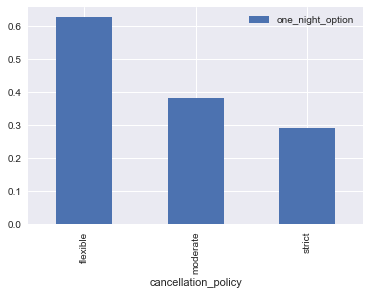

In [123]:
price_one_night = df2[['cancellation_policy','one_night_option']].groupby(['cancellation_policy']).mean().plot.bar()
price_one_night

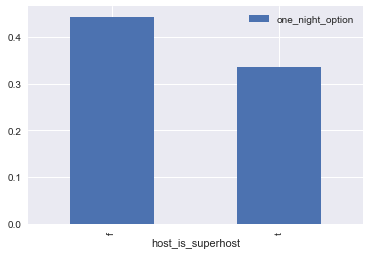

In [124]:
price_one_night = df2[['host_is_superhost','one_night_option']].groupby(['host_is_superhost']).mean().plot.bar()
price_one_night

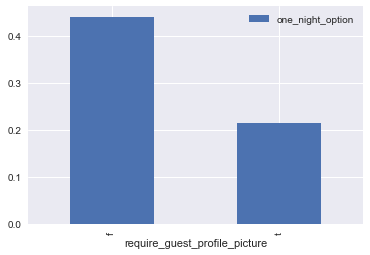

In [125]:
price_one_night = df2[['require_guest_profile_picture','one_night_option']].groupby(['require_guest_profile_picture']).mean().plot.bar()
price_one_night

# Summary

In summary, there are variables which show a relationship with whether or not an Airbnb property allows a one night rental option. They include price (more expensive properties are less likely to allow a one night option), the number of reviews (properties that have more are less likely to have one night options), cancellation policy (more strict cancellation policies are related to fewer offering a one night option), whether the host is a superhost (superhosts are less likely to have the one night option), and finally whether a host requires a guest profile picture (requiring one is related to fewer one night options)

In general, I would say that the results are similar to what I would expect.  One night options are less profitable than multi-night stays because you have to clean/prepare the room more often.  You also will be giving away more amenities (mini shampoo, soap, snacks) than for multi night stays. Therefore, I can see why new Airbnb hosts (non-superhosts) would be more willing to have a one night option in order to get reviews and hopefully get superhost status.  Once you have superhost status and reviews, however, you may be less likely to offer one night stays since they are more hassle and you can get along fine without them. 

Also, having a larger number of different renters in a given year increases the chance of having at least one bad renter who doesn't take care of the property and may result in damage costs.  Because of this, it would make sense that one night options are more likely to require more strict cancellation policies.  It may also make sense that higher priced properties have fewer one night options due to a desire to limit the number of people who might ruin a very nice property.

I was surprised to see that the one night options were less likely to require a guest profile picture.  However, I suppose similar to price that the higher priced places have more to lose if a bad guest trashes the place so having a picture for identity purposes might help ensure only guest willing to show their face get into the nice properties.  